# Análise de Grafos Logísticos - Projeto GCC218 (UFLA)

Este notebook é a **porta de entrada para o nosso analisador de grafos logísticos**, desenvolvido como parte do **Trabalho Prático Final da disciplina GCC218 - Algoritmos em Grafos** da Universidade Federal de Lavras (UFLA).

Aqui, você irá:

- **Carregar os dados de uma instância de grafo logístico** a partir de arquivos `.dat`;
- **Calcular estatísticas estruturais importantes** para entender a topologia e características do grafo;
- **Visualizar graficamente o grafo**, com destaque para as arestas e arcos obrigatórios e não obrigatórios;
- **Executar o algoritmo Path Scanning**, que gera rotas otimizadas para atender a todos os serviços obrigatórios respeitando a capacidade dos veículos;
- **Salvar e analisar os resultados** das rotas geradas.

---

## 🚀 Como este notebook funciona?

1. **Importação das bibliotecas necessárias e funções auxiliares:**  
   Ferramentas para leitura dos dados, cálculo das métricas e otimização das rotas.

2. **Leitura e processamento dos dados da instância:**  
   Interpretação do arquivo `.dat`, identificando nós, arestas, arcos e seus status (obrigatórios ou não).

3. **Cálculo da matriz de caminhos mínimos (Floyd-Warshall):**  
   Para garantir que as rotas sigam o trajeto de menor custo entre os pontos.

4. **Geração e análise das estatísticas do grafo:**  
   Métricas como grau, densidade, centralidade, caminho médio e diâmetro.

5. **Construção de rotas via algoritmo Path Scanning:**  
   Criando rotas viáveis e eficientes para veículos com capacidade limitada.

6. **Exibição dos resultados e visualização gráfica:**  
   Para melhor compreensão do problema e da solução.

7. **Comparação das soluções iniciais e otimizadas:** 
   O notebook também realiza a comparação entre as rotas geradas inicialmente e as soluções otimizadas pelo nosso otimizador próprio, destacando melhorias no custo total e eficiência.

---

## 💡 Dica para quem está começando:

Imagine o grafo como um mapa de cidades e estradas, onde algumas estradas são obrigatórias (como ruas que um caminhão precisa percorrer) e outras opcionais. Nosso objetivo é planejar rotas que cubram todas as obrigações gastando o mínimo possível e sem sobrecarregar os veículos.


---

## 1. Importação de Bibliotecas

Antes de tudo, importamos as bibliotecas necessárias e funções auxiliares responsáveis pela leitura dos dados, cálculo de estatísticas do grafo e cálculo das melhores rotas.

In [11]:
import sys
sys.path.append('./src')

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
import math
import random
import time
import os
from path_scanning import path_scanning
from salvar_solucao import salvar_resultado_arquivo
from estatisticas_grafo import EstatisticasGrafo
from otimizador import otimizar_solucao
from grafo import GrafoCARP


## 2. Leitura do Arquivo de Dados

Nesta etapa, realizamos a leitura do arquivo que contém os dados da instância do grafo logístico. Utilizamos a classe GrafoCARP para carregar e interpretar o arquivo, que contém as informações sobre os nós, arestas e arcos do grafo, separando as arestas obrigatórias das não obrigatórias.

In [12]:
nome_arquivo = input("Digite o nome do arquivo (por exemplo, BHW1.dat): ").strip()
caminho_arquivo = f"dados/{nome_arquivo}"

grafo_instancia = GrafoCARP(caminho_arquivo)  # cria o objeto GrafoCARP que já faz o parser
if not grafo_instancia or grafo_instancia.num_vertices == 0:
    print(f"⚠ Erro: dados inválidos no arquivo {caminho_arquivo}.")
else:
    print(f"✅ Grafo carregado com sucesso a partir de {caminho_arquivo}\n")

✅ Grafo carregado com sucesso a partir de dados/BHW1.dat



# 3. Cálculo das Estatísticas do Grafo

Com os dados do grafo carregados, utilizamos a classe EstatisticasGrafo para calcular informações relevantes sobre a estrutura do grafo, tais como: número de vértices, quantidade de arestas, grau mínimo e máximo dos nós, densidade, entre outras métricas importantes.

In [13]:
estatisticas = EstatisticasGrafo(grafo_instancia)
stats = estatisticas.calcular()

print(f"📊 Estatísticas do grafo ({caminho_arquivo}):")
for chave, valor in stats.items():
        # Formatando booleano para "Sim"/"Não"
    if isinstance(valor, bool):
        valor = "Sim" if valor else "Não"
    # Limitando floats a 4 casas decimais
    elif isinstance(valor, float):
        valor = f"{valor:.4f}"
    print(f"{chave}: {valor}")

📊 Estatísticas do grafo (dados/BHW1.dat):
1- Quantidade de vértices: 12
2- Quantidade de arestas: 11
3- Quantidade de arcos: 22
4- Quantidade de vértices obrigatórios: 7
5- Quantidade de arestas obrigatórias: 11
6- Quantidade de arcos obrigatórios: 11
7- É direcionado?: Sim
8- Densidade: 0.2500
9- Grau mínimo: 6
10- Grau máximo: 10
11- Intermedição: 1.3485
12- Caminho Médio: 16.7121
13- Diâmetro: 30


## 4. Posicionamento dos nós no espaço (visualização das interseções)

Aqui, cada ponto (ou nó) do grafo recebe uma posição no plano 2D para podermos visualizar o grafo como se fosse um mapa.

### Qual o objetivo?

Como os nós representam cruzamentos ou locais importantes, posicioná-los no plano ajuda a montar uma visão geral da rede de ruas. Isso facilita entender como as ruas estão conectadas e por onde os veículos podem circular.

### Como fizemos isso?

Geramos coordenadas aleatórias para cada nó dentro de uma área delimitada. Assim, conseguimos desenhar os pontos de forma distribuída, sem que fiquem colados nas bordas.

Mesmo sendo uma distribuição aleatória, ela já é suficiente para termos uma noção geral da estrutura do grafo e conseguirmos visualizar as conexões entre os nós depois.


In [18]:
largura, altura, margem = 10, 10, 1.5
posicoes = {no: (random.uniform(margem, largura - margem), random.uniform(margem, altura - margem))
    for no in range(1, grafo_instancia.num_vertices + 1)}

## 5. Visualização do grafo com cores específicas

Nesta parte, mostramos visualmente o grafo com as ruas e cruzamentos representados como conexões (arestas/arcos) e nós. A ideia é facilitar o entendimento das vias que precisam ou não ser percorridas no problema, além de deixar claro quando uma rua é mão única ou dupla.

### Como representamos as vias (ligações entre os nós):

- **Arestas obrigatórias (REE)**: São as ruas que devem ser atendidas e são de mão dupla. Aparecem como **linhas azuis sólidas**.
- **Arestas opcionais (EDGE)**: Ruas de mão dupla que podem ser usadas se forem vantajosas. Mostradas como **linhas ciano tracejadas**.
- **Arcos obrigatórios (REA)**: São vias obrigatórias de **mão única**. Aparecem como **setas verdes sólidas**.
- **Arcos opcionais (ARC)**: Vias de mão única que podem ser usadas ou não. Representadas por **setas roxas tracejadas**.

Cada via mostra também o seu **custo** (distância, tempo ou esforço para percorrer), indicado no meio da linha com um número.

### E os pontos (nós) do grafo:

- **Nós obrigatórios (REN)**: Representam locais que precisam ser visitados (como pontos de coleta). Aparecem como **círculos azul escuro** com o número branco no centro.
- **Nós opcionais**: São cruzamentos ou intersecções que podem ser usados apenas para passar. Aparecem como **círculos azul acinzentado**.

### Por que isso ajuda?

Essa visualização torna muito mais fácil:
- Ver quais ruas são mais importantes;
- Distinguir mão única de mão dupla;
- Entender como os custos estão distribuídos;
- Ter uma base clara para pensar em boas rotas.

Com isso, a estrutura do problema fica bem visível, e conseguimos partir para as próximas etapas com mais clareza.


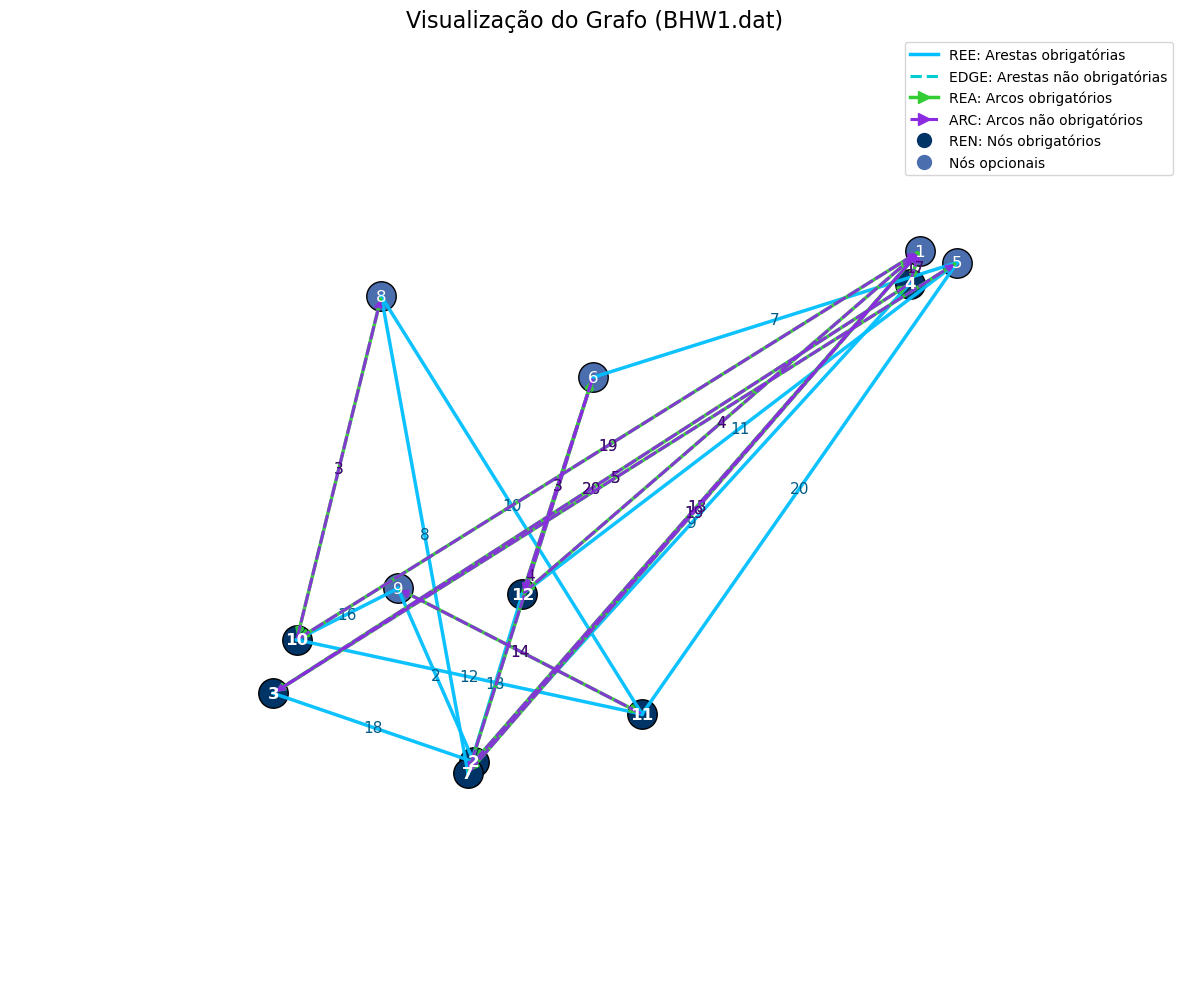

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))

dados_grafo = grafo_instancia.get_dados()

# Arestas obrigatórias
for u, v, custo, *_ in dados_grafo['arestas_obrigatorias']:
    x1, y1 = posicoes[u]
    x2, y2 = posicoes[v]
    ax.plot([x1, x2], [y1, y2], color='#00BFFF', linewidth=2.5, alpha=0.95)
    ax.text((x1 + x2)/2, (y1 + y2)/2, f'{custo}', color='#005c87', fontsize=11, ha='center', va='center')

# Arestas não obrigatórias
for u, v, custo, *_ in dados_grafo['arestas_nao_obrigatorias']:
    x1, y1 = posicoes[u]
    x2, y2 = posicoes[v]
    ax.plot([x1, x2], [y1, y2], color='#00CED1', linestyle='--', linewidth=2.2, alpha=0.85)
    ax.text((x1 + x2)/2, (y1 + y2)/2, f'{custo}', color='#007374', fontsize=11, ha='center', va='center')

# Arcos obrigatórios
for u, v, custo, *_ in dados_grafo['arcos_obrigatorios']:
    x1, y1 = posicoes[u]
    x2, y2 = posicoes[v]
    ax.annotate("",
                xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->", color='#32CD32', linewidth=2.5, alpha=0.95))
    ax.text((x1 + x2)/2, (y1 + y2)/2, f'{custo}', color='#1a7f1a', fontsize=11, ha='center', va='center')

# Arcos não obrigatórios
for u, v, custo, *_ in dados_grafo['arcos_nao_obrigatorios']:
    x1, y1 = posicoes[u]
    x2, y2 = posicoes[v]
    ax.annotate("",
                xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->", linestyle='--', color='#8A2BE2', linewidth=2.2, alpha=0.9))
    ax.text((x1 + x2)/2, (y1 + y2)/2, f'{custo}', color='#4b0082', fontsize=11, ha='center', va='center')

# Nós obrigatórios
for no, info in dados_grafo['nos'].items():
    x, y = posicoes[no]
    ax.scatter(x, y, color='#003366', s=450, edgecolors='black')
    ax.text(x, y, str(no), fontsize=12, ha='center', va='center', color='white', weight='bold')

# Nós opcionais
vertices_todos = set(range(1, grafo_instancia.num_vertices + 1))
vertices_obrigatorios = set(dados_grafo['nos'].keys())
vertices_opcionais = vertices_todos - vertices_obrigatorios

for no in vertices_opcionais:
    x, y = posicoes[no]
    ax.scatter(x, y, color='#4B6EAF', s=450, edgecolors='black')
    ax.text(x, y, str(no), fontsize=12, ha='center', va='center', color='white')

ax.set_title(f"Visualização do Grafo ({nome_arquivo})", fontsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, largura)
ax.set_ylim(0, altura)
ax.set_frame_on(False)

legenda = [
    Line2D([], [], color='#00BFFF', lw=2.5, label='REE: Arestas obrigatórias'),
    Line2D([], [], color='#00CED1', lw=2.2, linestyle='--', label='EDGE: Arestas não obrigatórias'),
    Line2D([], [], color='#32CD32', lw=2.5, label='REA: Arcos obrigatórios', marker='>', markersize=8),
    Line2D([], [], color='#8A2BE2', lw=2.2, linestyle='--', label='ARC: Arcos não obrigatórios', marker='>', markersize=8),
    Line2D([], [], marker='o', color='#003366', label='REN: Nós obrigatórios', markerfacecolor='#003366', markersize=10, linestyle='None'),
    Line2D([], [], marker='o', color='#4B6EAF', label='Nós opcionais', markerfacecolor='#4B6EAF', markersize=10, linestyle='None'),
]
ax.legend(handles=legenda, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Cálculo das melhores rotas e gravação do resultado

Nesta etapa, realizamos o cálculo das melhores rotas para cobrir todos os pontos obrigatórios do grafo logístico e salvamos o resultado em um arquivo `.dat`.

### Etapas realizadas:

- **Marcação dos tempos**: registramos o tempo total da execução e o tempo apenas do cálculo da solução para medir desempenho.
- **Cálculo das rotas**: utilizamos o método `path_scanning` para encontrar o melhor conjunto de rotas que cobre todos os pontos obrigatórios, considerando restrições de capacidade e minimizando o custo total.
- **Criação da pasta de saída**: garantimos que a pasta `solucoes` existe para armazenar o arquivo de resultado.
- **Gravação do resultado**: chamamos a função `salvar_resultado_arquivo`, que grava os detalhes do resultado e os tempos em um arquivo `.dat` para análise posterior.

In [16]:
inicio_total = time.monotonic_ns()

inicio_solucao = time.monotonic_ns()

resultado = path_scanning(grafo_instancia)
resultado_melhorado = otimizar_solucao(grafo_instancia, resultado)


fim_solucao = time.monotonic_ns()
fim_total = time.monotonic_ns()

tempo_geral = fim_total - inicio_total
tempo_algoritmo = fim_solucao - inicio_solucao

pasta_saida = "solucoes-finais"
os.makedirs(pasta_saida, exist_ok=True)  # cria a pasta se não existir

nome_saida = f"sol-{os.path.basename(caminho_arquivo).replace('.dat','')}.dat"
caminho_saida = os.path.join(pasta_saida, nome_saida)

salvar_resultado_arquivo(resultado_melhorado, tempo_geral, tempo_algoritmo, caminho_saida, grafo_instancia)

print(f"✅ Resultado salvo em {caminho_saida}")

✅ Resultado salvo em solucoes-finais/sol-BHW1.dat


## 7. Comparação dos Custos Totais Antes e Depois da Otimização

Após gerar a solução inicial com o algoritmo **Path Scanning**, aplicamos um processo de **otimização local** que redistribui serviços entre rotas com o objetivo de **reduzir o custo total** da solução logística.

Nesta etapa final, comparamos os **custos totais das rotas antes e depois da otimização** para cada instância analisada. Apenas os casos em que houve diferença de custo são exibidos, evidenciando a melhoria obtida.

O relatório a seguir destaca os resultados:

- 📄 **Nome da instância** (arquivo `.dat`);
- 💸 **Custo total antes da otimização**;
- 🛠️ **Custo total após a otimização**

In [17]:
import os

pasta_dados = "dados"
pasta_solucoes_finais = "solucoes-finais"
pasta_solucoes_finais_iniciais = "solucoes-iniciais"

arquivos_dados = sorted([
    f for f in os.listdir(pasta_dados)
    if f.endswith(".dat")
])

print("🔍 Comparando custo total antes e depois da melhoria")

for nome_arquivo in arquivos_dados:
    nome_saida = f"sol-{nome_arquivo.replace('.dat', '')}.dat"

    caminho_solucao = os.path.join(pasta_solucoes_finais, nome_saida)
    caminho_solucao_0 = os.path.join(pasta_solucoes_finais_iniciais, nome_saida)

    if not os.path.exists(caminho_solucao):
        print(f"⚠ Faltando em 'solucoes finais': {nome_saida}")
        continue
    if not os.path.exists(caminho_solucao_0):
        print(f"⚠ Faltando em 'solucoes finais': {nome_saida}")
        continue

    with open(caminho_solucao, "r", encoding="utf-8-sig") as f1, open(caminho_solucao_0, "r", encoding="utf-8-sig") as f2:
        linha1_f1 = f1.readline().strip().replace('\r', '')
        linha1_f2 = f2.readline().strip().replace('\r', '')

        if linha1_f1 != linha1_f2:
            print(f"\n🔁 Diferença em: {nome_saida}")
            print(f"👉 Custo Total antes da melhoria: {linha1_f2}")
            print(f"👉 Custo Total depois da melhoria: {linha1_f1}")


🔍 Comparando custo total antes e depois da melhoria

🔁 Diferença em: sol-BHW1.dat
👉 Custo Total antes da melhoria: 404
👉 Custo Total depois da melhoria: 274

🔁 Diferença em: sol-BHW10.dat
👉 Custo Total antes da melhoria: 12629
👉 Custo Total depois da melhoria: 12331

🔁 Diferença em: sol-BHW12.dat
👉 Custo Total antes da melhoria: 15092
👉 Custo Total depois da melhoria: 13661

🔁 Diferença em: sol-BHW13.dat
👉 Custo Total antes da melhoria: 19093
👉 Custo Total depois da melhoria: 18195

🔁 Diferença em: sol-BHW14.dat
👉 Custo Total antes da melhoria: 31199
👉 Custo Total depois da melhoria: 29267

🔁 Diferença em: sol-BHW15.dat
👉 Custo Total antes da melhoria: 19201
👉 Custo Total depois da melhoria: 18328

🔁 Diferença em: sol-BHW16.dat
👉 Custo Total antes da melhoria: 54069
👉 Custo Total depois da melhoria: 49908

🔁 Diferença em: sol-BHW17.dat
👉 Custo Total antes da melhoria: 31447
👉 Custo Total depois da melhoria: 30331

🔁 Diferença em: sol-BHW18.dat
👉 Custo Total antes da melhoria: 20234
👉 C

## 8. Conclusão

Este notebook apresentou uma solução completa para o problema de roteamento capacitado em grafos logísticos, com foco na cobertura eficiente de ruas e pontos obrigatórios em instâncias do tipo CARP (Capacitated Arc Routing Problem).

Ao longo do processo, foram realizadas as seguintes etapas:

- 📊 **Análise estrutural do grafo**: calculamos estatísticas como número de vértices, grau, densidade e conectividade, oferecendo uma base sólida para compreensão da instância.
- 🗺️ **Visualização espacial da rede**: posicionamos os nós em um plano 2D e representamos visualmente os diferentes tipos de vias (mão única, mão dupla, obrigatórias e opcionais), o que facilitou a interpretação topológica da rede.
- 🔍 **Geração de solução inicial**: utilizamos a heurística **Path Scanning** para encontrar rotas que atendem todas as demandas obrigatórias, respeitando a capacidade dos veículos e minimizando o custo.
- ♻️ **Otimização da solução**: aplicamos uma estratégia de melhoria baseada em **realocação de serviços entre rotas**, priorizando rotas de maior custo e serviços com maior impacto, com o objetivo de reduzir ainda mais o custo total.
- 📉 **Comparação de desempenho**: por fim, comparamos os custos totais antes e depois da otimização para cada instância, destacando apenas os casos com melhoria significativa.

---

🔚 **Resultado Final**:  
A abordagem adotada se mostrou eficiente para gerar soluções iniciais viáveis e melhorá-las de forma iterativa, mantendo o tempo de execução baixo. O pipeline desenvolvido pode ser facilmente reaproveitado ou estendido com novas heurísticas e meta-heurísticas mais sofisticadas, como LNS, GRASP ou Simulated Annealing.

Esse processo representa uma base sólida para aplicações reais em logística urbana e planejamento de serviços em redes viárias.

